# Stitching Trajecrories Example:

This example uses a different implementation by @yosefm (see issue on openptv/postptv)


In [1]:
import numpy as np
np.set_printoptions(precision=3)

import itertools as it

from matplotlib.ticker import FormatStrFormatter
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.legend import Legend


# from utils import get_traj_list

import itertools as it, numpy as np
import matplotlib.pyplot as plt

from flowtracks.scene import Scene
from flowtracks.trajectory import Trajectory

##### Figure Formats:

In [2]:
%matplotlib inline

params = {'legend.fontsize': 13,#'x-large',
          'figure.figsize': (7.2, 4.45),#(6, 4.5),
         'axes.labelsize':17,#'xx-large',
         'axes.titlesize':16,#'xx-large',
         'xtick.labelsize':16,#'xx-large',
         'ytick.labelsize':16,#'xx-large',
         'font.size':15,
         'mathtext.fontset': 'stix',
         'font.family': 'STIXGeneral',
         # 'font.family': ['serif'],
         # 'font.sans-serif' : 'Computer Modern Roman',
         'grid.color': '#c1c1c1',
         'text.usetex' : 'False', # set True and see if it works for your LaTeX installation
         'legend.framealpha' : '1.0',
         'lines.markersize': 6,
         'lines.markeredgewidth': '0.5'}

    
pylab.rcParams.update(params)


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
shapes = ['X','o', 'd', 'v', '^', '<', '>', 'P', '8', 's', 'p', '*', 'h', 'H', 'D']

In [3]:
file_path = 'traj_data.h5'
scn = Scene(file_path)

In [4]:
# Though this won't be necessary if you don't save the short ones at all in the
# HDF conversion.
minLength = 10;       # length of elemnts in the trajs

long_trajects = filter(
    lambda trj: len(trj) > minLength, scn.iter_trajectories())

In [5]:

traj_list = list(long_trajects)

print('%d trajectories' % (len(traj_list)))

200 trajectories


In [6]:
#get the "recording" frame rate
frate = len(traj_list[0]) / 4.0
print('%.f fps' % frate)

38 fps


# Prepare a list of 20 broken Trajectories:

To demonstrate and test the code, we take 20 trajectories from the dataset provided with this library and break each of them into 2 segments at a random time. We remove 3 frames of data in between the two segments.

In [7]:

broken_trajectories = []

e = 1

for traj in traj_list[:20]:
    
    brk_pnt = np.random.randint(1,len(traj_list[0])-10)

    segment1 = Trajectory(traj.pos()[:brk_pnt], 
                          traj.velocity()[:brk_pnt],
                          traj.time()[:brk_pnt],
                          e,
                          accel = traj.accel()[:brk_pnt])
    
    segment2 = Trajectory(traj.pos()[brk_pnt+3:], 
                          traj.velocity()[brk_pnt+3:],
                          traj.time()[brk_pnt+3:],
                          e+1,
                          accel = traj.accel()[brk_pnt+3:])
    
    broken_trajectories.append(segment1)
    
    broken_trajectories.append(segment2)
    
    e += 2

print('%d broken trajectories'%(len(broken_trajectories)))

40 broken trajectories


In [8]:
distThresh = 0.2 # in other files it can be much lower, e.g. 0.003   
maxDt = 5/frate


links = {}
back_links = {}

for trj1, trj2 in it.combinations(broken_trajectories, 2):
    dt = (trj2.time(0) - trj1.time(-1))/frate
    if not (0 < dt <= maxDt):
        continue
    
    master_id = trj1.trajid()
    slave_id = trj2.trajid()
    links.setdefault(master_id, (None, distThresh))
    back_links.setdefault(slave_id, (None, distThresh))
    min_dist = min(links[master_id][1], back_links[slave_id][1])
    
    # Continue trj1 forward one time interval, and trj2 backward one interval.
    # If the evarage distance between each predicted point and the other traj's
    # endpoint meets the criteria - connect.
    predicted_forward = trj1.pos(-1) + dt*trj1.velocity(-1)
    predicted_backward = trj2.pos(0) - dt*trj2.velocity(0)
    dist_forward = np.linalg.norm(predicted_forward - trj2.pos(0))
    dist_backward = np.linalg.norm(predicted_backward - trj1.pos(-1))
    
    # Possible register candidate:
    avg_dist = (dist_forward + dist_backward)/2.
    if avg_dist < min_dist:
        old_link = back_links[slave_id][0]
        if old_link is not None:
            links[old_link] = (None, distThresh)
        links[master_id] = (slave_id, avg_dist)
        back_links[slave_id] = (master_id, avg_dist)
 
print(("candidates:", links))

# Weld the final best candidates.
out_trajects = []
used_trids = set() # don't repeat taken candidates as masters.
for trid, cand in list(links.items()):
    if trid in used_trids:
        continue
    
    trj_weld = scn.trajectory_by_id(trid)
    while cand[0] is not None:
        used_trids.add(cand[0])
        trj1 = trj_weld
        trj2 = scn.trajectory_by_id(cand[0])
        trj_weld = Trajectory(
            np.vstack((trj1.pos(), trj2.pos())),
            np.vstack((trj1.velocity(), trj2.velocity())),
            trajid=trj1.trajid(),
            time=np.hstack((trj1.time(), trj2.time())),
            accel=np.vstack((trj1.accel(), trj2.accel())),
        )
        
        if cand[0] not in links:
            break
        cand = links[cand[0]]
        
    out_trajects.append(trj_weld)

('candidates:', {1: (2, 0.05985675007104874), 3: (4, 0.11425373703241348), 5: (6, 0.09631609916687012), 7: (8, 0.06719090044498444), 9: (10, 0.11497505009174347), 11: (12, 0.07755493372678757), 13: (14, 0.05890650302171707), 15: (16, 0.06800055503845215), 17: (18, 0.10621172189712524), 19: (20, 0.07771581411361694), 21: (22, 0.09578196704387665), 23: (24, 0.06564322113990784), 25: (26, 0.12878811359405518), 27: (28, 0.09381069988012314), 29: (30, 0.10482603311538696), 31: (32, 0.12403389811515808), 33: (34, 0.0738721489906311), 35: (36, 0.06393370032310486), 37: (38, 0.07935141026973724), 39: (40, 0.11512542515993118)})


In [9]:
    def plot_connected_trajectories(traj_list):
        fig, ax = plt.subplots(2,1, sharex=True)
        
        for tr in traj_list:
            ax[0].plot(tr.pos()[:,0], tr.pos()[:,1],'-x',color='r',ms=3,mew=1.5)
            ax[1].plot(tr.pos()[:,0], tr.pos()[:,2],'-x',color='r',ms=3,mew=1.5)
            
        # for i in self.connect_list:
        #     tr = self.t[i[0]]
        #     ax[0].plot(tr.pos()[:,0], tr.pos()[:,1],'-o',color='b',ms=2)
        #     ax[1].plot(tr.pos()[:,0], tr.pos()[:,2],'-o',color='b',ms=3)
        #     tr = self.t[i[1]]
        #     ax[0].plot(tr.pos()[:,0], tr.pos()[:,1],'-o',color='b',ms=2)
        #     ax[1].plot(tr.pos()[:,0], tr.pos()[:,2],'-o',color='b',ms=2)
        
        ax[1].set_xlabel('x')
        ax[0].set_ylabel('y')
        ax[1].set_ylabel('z')
        ax[0].set_aspect('equal')
        ax[1].set_aspect('equal')
        return fig, ax

In [10]:
new_connected_tra_list = list(out_trajects)
print('%d connected trajectories' % (len(new_connected_tra_list)))

20 connected trajectories


(<Figure size 518.4x320.4 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0xb220a9cd0>,
       dtype=object))

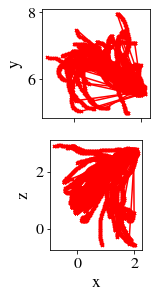

In [11]:
plot_connected_trajectories(out_trajects)